In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, learning_curve, validation_curve, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, RocCurveDisplay
import seaborn as sns

np.random.seed(42)
plt.rcParams['figure.figsize'] = (7,4)


In [3]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

print(X.shape, y.shape)
X.head()


(569, 30) (569,)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape


((455, 30), (114, 30))

Decision Tree Test Accuracy: 0.9123

Classification Report (Decision Tree)
              precision    recall  f1-score   support

           0       0.85      0.93      0.89        42
           1       0.96      0.90      0.93        72

    accuracy                           0.91       114
   macro avg       0.90      0.92      0.91       114
weighted avg       0.92      0.91      0.91       114



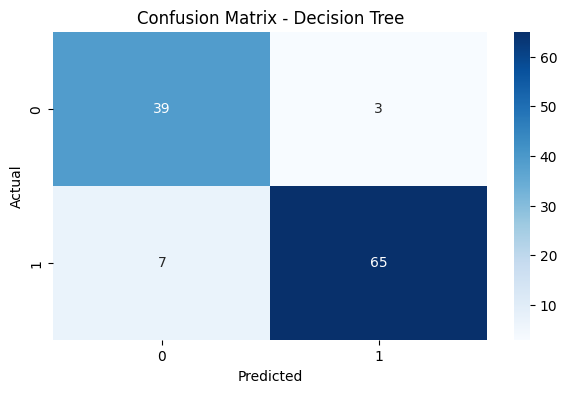

In [5]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Test Accuracy: {acc_dt:.4f}")

print("\nClassification Report (Decision Tree)")
print(classification_report(y_test, y_pred_dt))

cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

Bagging Test Accuracy: 0.9386
OOB Score (approx CV): 0.9560


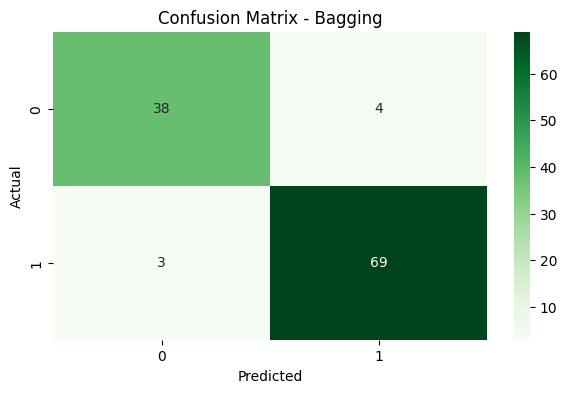

In [6]:
bag = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=100,
    max_samples=1.0,
    max_features=1.0,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=42
)
bag.fit(X_train, y_train)
y_pred_bag = bag.predict(X_test)

acc_bag = accuracy_score(y_test, y_pred_bag)
print(f"Bagging Test Accuracy: {acc_bag:.4f}")
print(f"OOB Score (approx CV): {bag.oob_score_:.4f}")

cm_bag = confusion_matrix(y_test, y_pred_bag)
sns.heatmap(cm_bag, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - Bagging")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

Random Forest Test Accuracy: 0.9561


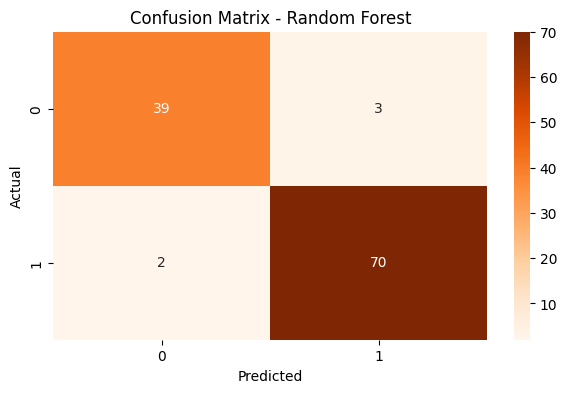

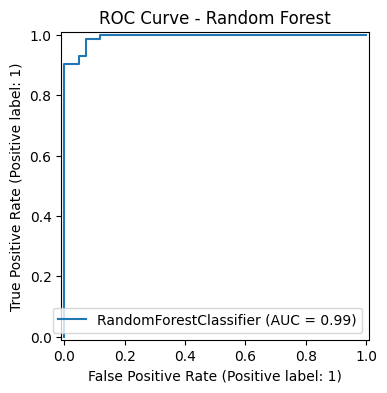

In [8]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    max_features="sqrt",
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Test Accuracy: {acc_rf:.4f}")

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Oranges")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()


RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title("ROC Curve - Random Forest")
plt.show()

In [9]:
summary = pd.DataFrame({
    "Model": ["Decision Tree", "Bagging (DT)", "Random Forest"],
    "Test Accuracy": [acc_dt, acc_bag, acc_rf]
})
summary

,Model,Test Accuracy
0,Decision Tree,0.912281
1,Bagging (DT),0.938596
2,Random Forest,0.956140


In [10]:
param_grid = {
    "n_estimators": [100, 200],
    "max_features": ["sqrt", 0.5, None],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

rf_tune = RandomForestClassifier(random_state=42, n_jobs=-1)
grid = GridSearchCV(
    rf_tune, param_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=0
)
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
best_rf = grid.best_estimator_
y_pred_best = best_rf.predict(X_test)
print("Best RF Test Accuracy:", accuracy_score(y_test, y_pred_best))


Best Params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best RF Test Accuracy: 0.9473684210526315


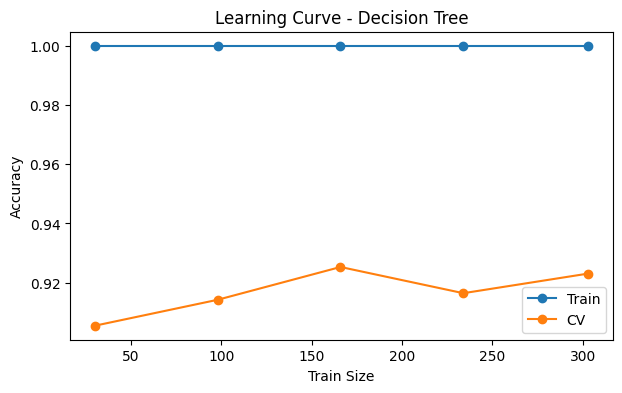

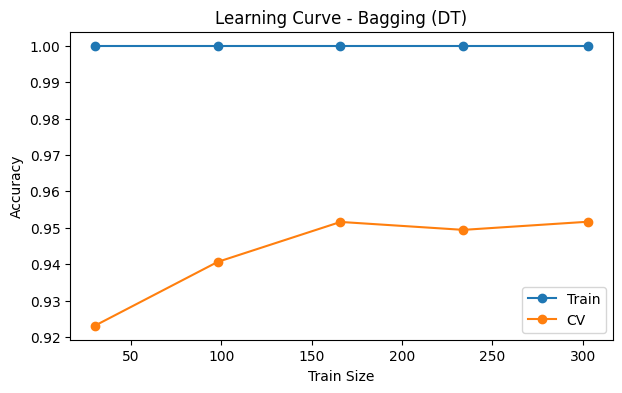

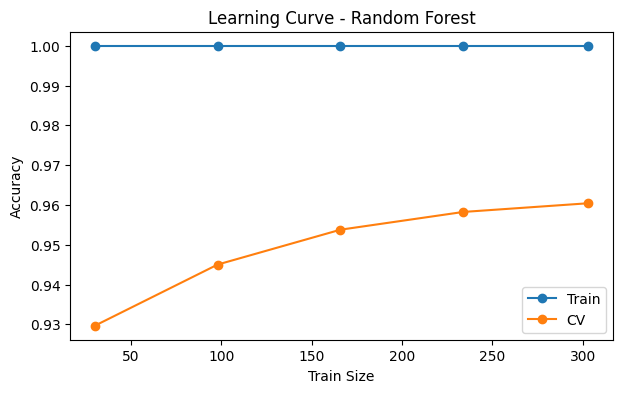

In [11]:
def plot_learning_curve(estimator, title):
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator, X_train, y_train, cv=3, scoring="accuracy",
        n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5), shuffle=True, random_state=42
    )
    train_mean = train_scores.mean(axis=1)
    valid_mean = valid_scores.mean(axis=1)

    plt.plot(train_sizes, train_mean, marker='o', label='Train')
    plt.plot(train_sizes, valid_mean, marker='o', label='CV')
    plt.title(title); plt.xlabel("Train Size"); plt.ylabel("Accuracy"); plt.legend(); plt.show()

plot_learning_curve(DecisionTreeClassifier(random_state=42), "Learning Curve - Decision Tree")
plot_learning_curve(BaggingClassifier(DecisionTreeClassifier(), n_estimators=100, n_jobs=-1, random_state=42),
                    "Learning Curve - Bagging (DT)")
plot_learning_curve(RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42),
                    "Learning Curve - Random Forest")


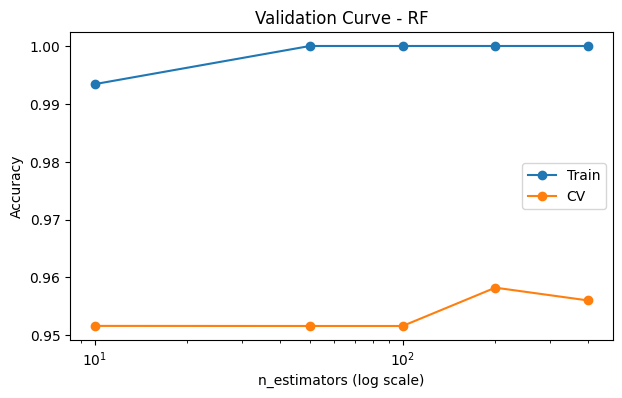

In [12]:
param_range = [10, 50, 100, 200, 400]
train_scores, valid_scores = validation_curve(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    X_train, y_train, param_name="n_estimators", param_range=param_range,
    cv=3, scoring="accuracy", n_jobs=-1
)
plt.plot(param_range, train_scores.mean(axis=1), marker='o', label="Train")
plt.plot(param_range, valid_scores.mean(axis=1), marker='o', label="CV")
plt.xscale('log'); plt.xlabel("n_estimators (log scale)"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Validation Curve - RF")
plt.show()

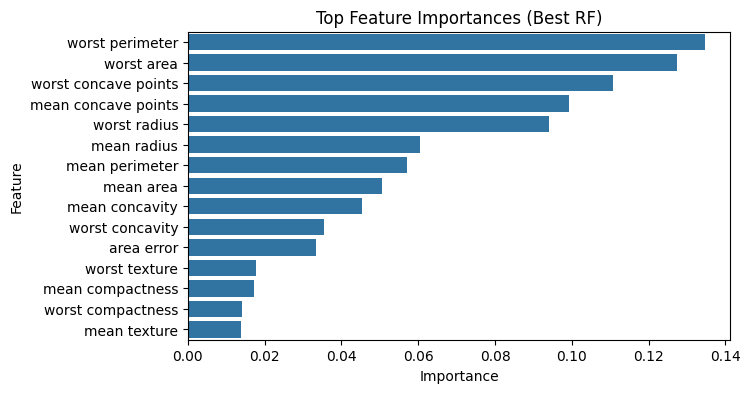

In [13]:
imp = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)[:15]
sns.barplot(x=imp.values, y=imp.index)
plt.title("Top Feature Importances (Best RF)"); plt.xlabel("Importance"); plt.ylabel("Feature")
plt.show()


In [14]:
import numpy as np
mis_idx = np.where(y_pred_best != y_test)[0]
print(f"Misclassified samples: {len(mis_idx)}")
if len(mis_idx) > 0:
    show = min(5, len(mis_idx))
    ix = mis_idx[:show]
    pd.concat([X_test.iloc[ix].reset_index(drop=True), y_test.iloc[ix].reset_index(drop=True).rename("true"),
               pd.Series(y_pred_best[ix], name="pred")], axis=1)
else:
    print("No misclassifications on this split!")


Misclassified samples: 6


In [15]:
X_test_noisy = X_test.copy()
noise = np.random.normal(0, 0.01, size=X_test_noisy.shape)
X_test_noisy = X_test_noisy + noise

y_pred_noisy = best_rf.predict(X_test_noisy)
acc_noisy = accuracy_score(y_test, y_pred_noisy)
print("Accuracy with noise:", acc_noisy)
print("Prediction stability (% unchanged):", (y_pred_noisy == y_pred_best).mean()*100)


Accuracy with noise: 0.9473684210526315
Prediction stability (% unchanged): 98.24561403508771
